## Keras (frontend) & tensorflow (backend)

In [1]:
import os
import keras

os.environ["KERAS_BACKEND"] = "tensorflow"

## Loading mnist dataset

In [2]:
from keras import datasets

(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

# 60000 images of 28x28 dimension
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (60000, 28, 28)
y_train shape: (60000,)


Let's display the first 10 images in the dataset.

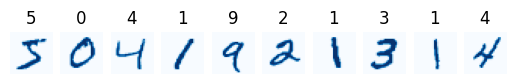

In [3]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i], cmap="Blues")
    plt.title(y_train[i])
    plt.axis("off")

## Reshape inputs
Let's now reshape the data to have a single array with 28x28=784 pixels, so that we can feed it as an input for our siamese network.

In [4]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (60000, 784)
X_test shape: (10000, 784)


## Normalization

Let's normalize each image to values between 0 and 1 via min-max normalization.

In [5]:
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

## Generating positive/negative pairs

Let's start by generating 60 000 positive pairs, and 60 000 negative pairs (120 000 pairs total) to train our siamese network.

In [6]:
import numpy as np

def generate_pairs(X, y):
    X_pairs, y_pairs = [], []

    for i in range(len(X)):
        label = y[i]

        # Positive pairs
        positive_label_index = np.random.choice(np.where(y == label)[0])
        X_pairs.append([X[i], X[positive_label_index]])
        y_pairs.append([0])

        # Negative pairs
        negative_label_index = np.random.choice(np.where(y != label)[0])
        X_pairs.append([X[i], X[negative_label_index]])
        y_pairs.append([1])

    # Breaking alternate pos/neg
    indices = np.arange(len(X_pairs))
    np.random.shuffle(indices)
    
    # Return array in shuffled order
    return np.array(X_pairs)[indices], np.array(y_pairs)[indices]

In [7]:
X_train_pairs, y_train_pairs = generate_pairs(X_train, y_train)
X_test_pairs, y_test_pairs = generate_pairs(X_test, y_test)

print("X_train_pairs shape:", X_train_pairs.shape)
print("X_test_pairs shape:", X_test_pairs.shape)

X_train_pairs shape: (120000, 2, 784)
X_test_pairs shape: (20000, 2, 784)


Let's do a little verification to see if the pairs were done correctly before proceeding in creating our siamese network.

In [8]:
def display_pairs(X, y, n_pairs, correct=None):
    plt.figure(figsize=(20,6))
    for i, (image1, image2) in enumerate(zip(X[:n_pairs, 0], X[:n_pairs, 1])):
        label = int(y[:n_pairs][i][0])
        title = "Positive" if label == 0 else "Negative"
        color = "lightseagreen"

        if correct is not None:
            title = "Same" if label == 0 else "Different"
            color = "mediumseagreen" if correct[:n_pairs][i][0] else "indianred"
        
        ax = plt.subplot(3, n_pairs, i+1)
        ax.text(
            1, -3, title, style="italic", bbox={"facecolor": color, "pad": 4}
        )

        plt.imshow(image1.reshape(28,28), cmap="Blues")
        plt.axis("off")

        ax = plt.subplot(3, n_pairs, i+1+n_pairs)
        plt.imshow(image2.reshape(28,28), cmap="Blues")
        plt.axis("off")

    plt.show()

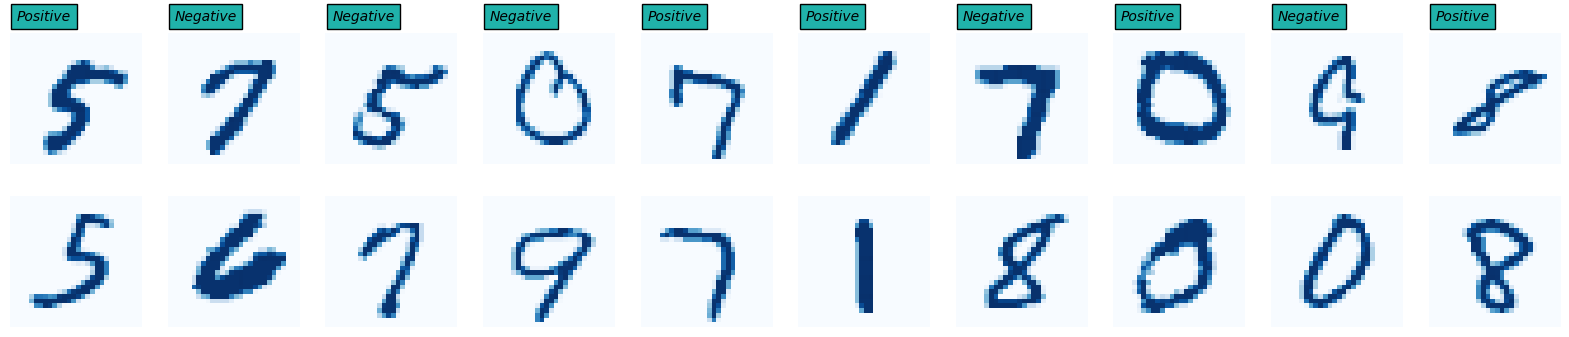

In [9]:
display_pairs(X_train_pairs, y_train_pairs, n_pairs=10)

## Building the model

Let's first defining the inputs for our pair of images.

In [10]:
from keras import Input

input1 = Input(shape=(784,))
input2 = Input(shape=(784,))

Now, let's build the body of the siamese network

In [11]:
from keras.layers import Dense
from keras.models import Sequential

network = Sequential(
    [
        Input(shape=(784,)),

        Dense(512, activation="relu"),
        Dense(256, activation="relu"),

        # Getting the raw embeddings, no activation
        # Small sized embeddings (Casual Project)
        Dense(128, activation=None),
    ]
)

Using the same network instance to share the same weights.

In [12]:
twin1, twin2 = network(input1), network(input2)

Defining a Lambda layer that calculates the Euclidean distance, and calculating the distance between embeddings.

In [13]:
from keras.layers import Lambda
from keras.ops import norm

def euclidean_distance(twins):
    twin1_output, twin2_output = twins
    return norm(twin1_output - twin2_output, axis=1, keepdims=True)

In [14]:
distance = Lambda(euclidean_distance)([twin1, twin2])

All we need to do now is assemble the inputs and ouput model together.

In [15]:
from keras import Model

model = Model(inputs=[input1, input2], outputs=distance)

## Defining a Loss function

Let's try using the Contrastive Loss from the following research paper : [Dimensionality Reduction by Learning an Invariant Mapping](https://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf)

In [16]:
from keras.ops import cast, maximum, square

def contrastive_loss(y,d):
    margin = 1
    y = cast(y, d.dtype)

    loss = (1-y)/2*square(d) + y/2*square(maximum(0.0, margin-d))
    return loss

## Compiling the model

Let's now compile the model with Contrastive Loss, Adam optimizer and Binary accuracy as our metrics in order to train it.

In [17]:
from keras.metrics import binary_accuracy

model.compile(loss=contrastive_loss, optimizer="adam", metrics=[binary_accuracy])

Let's use keras built-in tools to preview the architecture of our model.

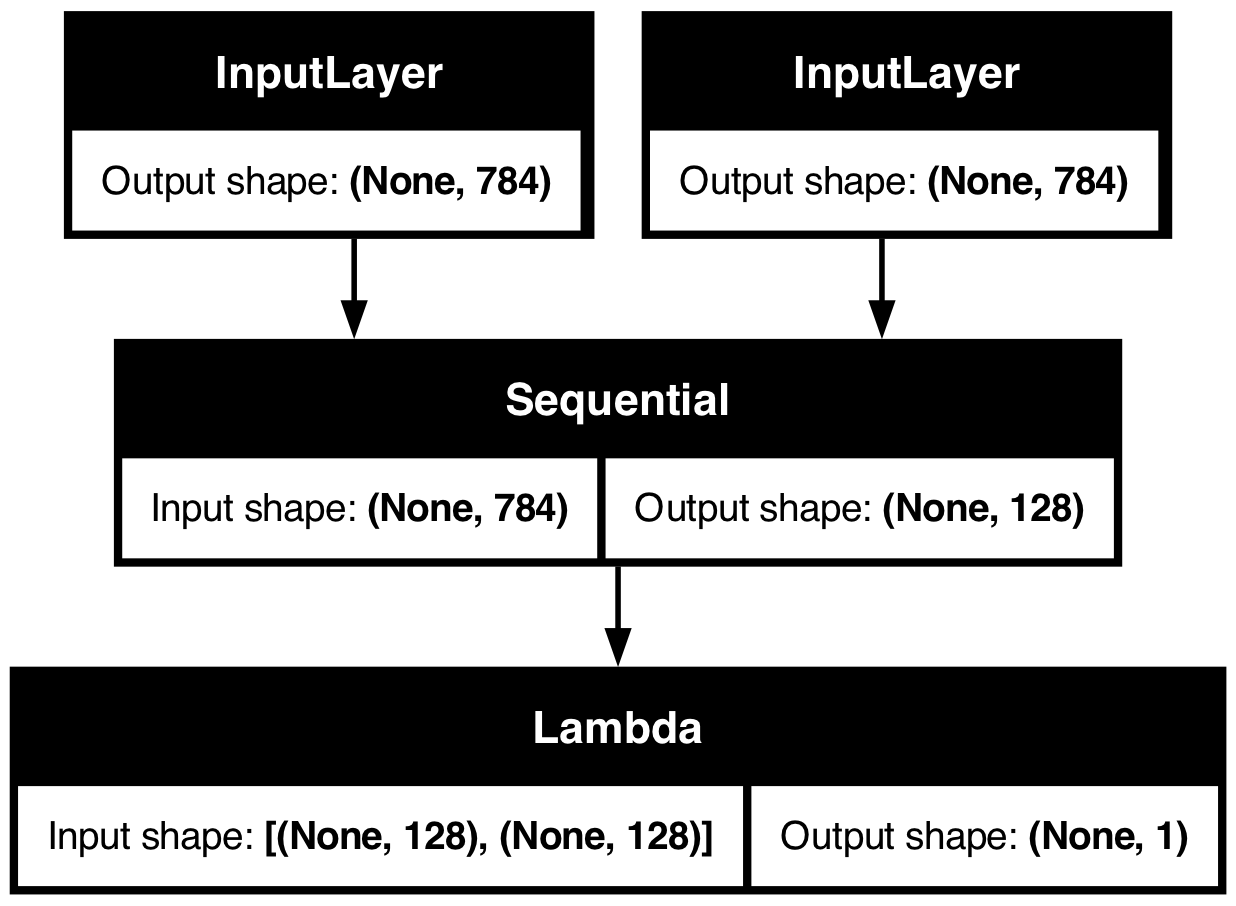

In [18]:
keras.utils.plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=False)

## Training the model

Let's go ahead and train our model. This might take a couple of minutes to fit the model...

In [19]:
history = model.fit(
    x=[X_train_pairs[:,0], X_train_pairs[:,1]],
    y=y_train_pairs[:],
    validation_data=([X_test_pairs[:,0], X_test_pairs[:,1]],y_test_pairs[:]),
    batch_size=32,
    epochs=5,
)

Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - binary_accuracy: 0.8954 - loss: 0.0488 - val_binary_accuracy: 0.9665 - val_loss: 0.0203
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - binary_accuracy: 0.9766 - loss: 0.0161 - val_binary_accuracy: 0.9676 - val_loss: 0.0171
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - binary_accuracy: 0.9859 - loss: 0.0112 - val_binary_accuracy: 0.9699 - val_loss: 0.0158
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - binary_accuracy: 0.9902 - loss: 0.0086 - val_binary_accuracy: 0.9697 - val_loss: 0.0144
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - binary_accuracy: 0.9924 - loss: 0.0069 - val_binary_accuracy: 0.9738 - val_loss: 0.0128


Let's plot the train and validation loss during training.

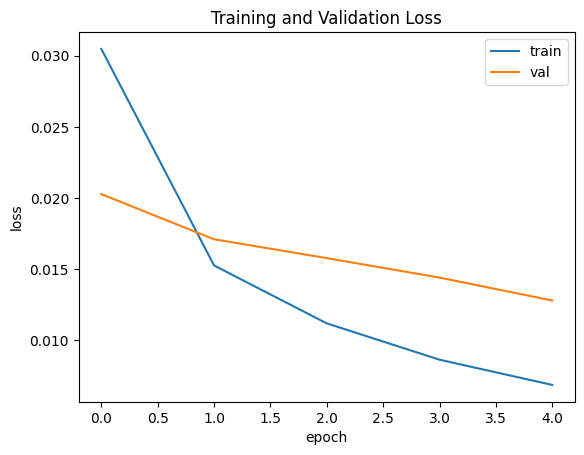

In [20]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training and Validation Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")
plt.show()

## Evaluation

Let's do the evaluation now.

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


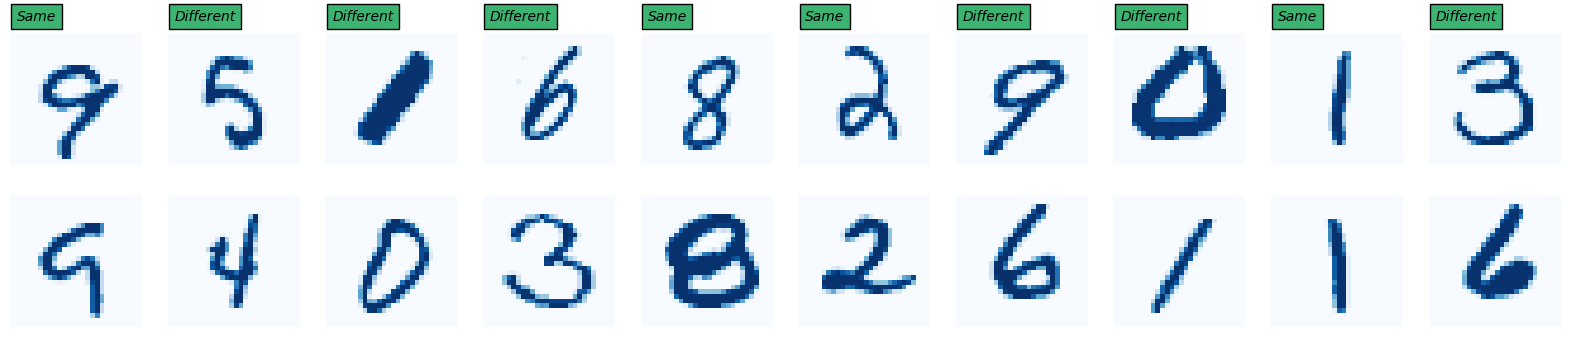

In [22]:
predictions = model.predict([X_test_pairs[:,0], X_test_pairs[:,1]]) >= 0.5
display_pairs(X_test_pairs, predictions, n_pairs=10, correct=predictions == y_test_pairs)

Computing the binary accuracy of the model on the test data. We get an accuracy of : 0.97. Not bad, not bad.

In [23]:
accuracy = keras.metrics.BinaryAccuracy()
accuracy.update_state(y_test_pairs, predictions.astype(int))
print(f"Accuracy: {accuracy.result().numpy():.2f}")

Accuracy: 0.97


## Extracting the portion of the Siamese Network to generate embedding

Looks like we need the index of `2` to get the part of our Siamese Network that generates the embeddings we want.

In [24]:
model.layers

[<InputLayer name=input_layer, built=True>,
 <InputLayer name=input_layer_1, built=True>,
 <Sequential name=sequential, built=True>,
 <Lambda name=lambda, built=True>]

In [25]:
embedding_model = model.layers[2]

## Embedded model test

Let's test it out by randomly selecting and comparing two numbers `2` and one number `5`.

In [26]:
digits = np.where(y_test == 2)[0]
index1 = np.random.choice(digits)
index2 = np.random.choice(digits)
index3 = np.random.choice(np.where(y_test == 5)[0])

Generate the embeddings

In [27]:
embedding1 = embedding_model.predict(X_test[index1].reshape(1, -1))
embedding2 = embedding_model.predict(X_test[index2].reshape(1, -1))
embedding3 = embedding_model.predict(X_test[index3].reshape(1, -1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


We can observe that the embeddings of the first two images are quite close to each other.

In [28]:
norm(embedding1 - embedding2).numpy()

0.02232547

And finally, the first two (number 2) are significantly distant from the embedding generate for the number 5.

In [29]:
norm(embedding1 - embedding3).numpy(), norm(embedding2 - embedding3).numpy()

(1.1002994, 1.085725)